Training a logistic regressor to identify memes
----------------------------------------------
Load VGGNet and shift it to GPU.

In [1]:
require 'cunn'
require 'loadcaffe'
require 'optim'
vgg = loadcaffe.load('VGGNet/VGG_ILSVRC_19_layers_deploy.prototxt.txt','VGGNet/VGG_ILSVRC_19_layers.caffemodel')
vgg:cuda()

Successfully loaded VGGNet/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


Function to pass an image through the VGGNet.

In [2]:
function forward_image(vgg, image_path)
    im = image.load(image_path)
    --print(im:size())
    siz = im:size()
    if siz[1] > 3 then
        im = im[{{1,3}}]
    elseif siz[1] < 3 then
        newim = torch.Tensor(3, siz[2], siz[3])
        newim[1] = im[1]
        newim[2] = im[1]
        newim[3] = im[1]
        im = newim
    end
    scaled = image.scale(im,224,224)
    scaled = scaled:cuda()
    scaled = scaled*256
    scaled[1] = scaled[1] - 123.68
    scaled[2] = scaled[2] - 116.779
    scaled[3] = scaled[3] - 103.939
    --print(scaled:size())
    return vgg:forward(scaled)
end

Load data saved from feature generation itorch document.

In [3]:
data = torch.load("meme_features.t7")

In [4]:
data

{
  1 : FloatTensor - size: 39000x4096
  2 : LongTensor - size: 39000
  3 : 
    {
      1 : Brian-Williams-Was-There
      2 : Yall-Got-Any-More-Of
      3 : The-Critic
      4 : Serious-Xzibit
      5 : Not-Okay-Rage-Face
      6 : Lewandowski-E-Reus
      7 : Frowning-Nun
      8 : Original-Bad-Luck-Brian
      9 : But-Thats-None-Of-My-Business
      10 : Scared-Cat
      11 : Fim-De-Semana
      12 : Barack-And-Kumar-2013
      13 : Derpina
      14 : Simba-Shadowy-Place
      15 : The-Bobs
      16 : Overly-Attached-Girlfriend
      17 : Successful-Black-Man
      18 : Hedonism-Bot
      19 : Smirk-Rage-Face
      20 : Officer-Cartman
      21 : Luiz-Fabiano
      22 : Bothered-Bond
      23 : Slenderman
      24 : Advice-Yoda
      25 : Hey-Internet
      26 : So-Much-Drama
      27 : House-Bunny
      28 : RPG-Fan
      29 : Too-Damn-High
      30 : Metal-Jesus
      31 : Dexter
      32 : Sweaty-Concentrated-Rage-Face
      33 : Rebecca-Black
      34 : Dr-Evil
      35 : Tough

78 : Beyonce-Knowles-Superbowl
      79 : Corona
      80 : Why-Not-Both
      81 : Wrong-Number-Rita
      82 : Impossibru-Guy-Original
      83 : Disappointed-Tyson
      84 : Socially-Awesome-Penguin
      85 : Photogenic-Scene-Guy
      86 : Brian-Burke-On-The-Phone
      87 : Super-Cool-Ski-Instructor
      88 : Rick-and-Carl-Longer
      89 : Eminem
      90 : Tennis-Defeat
      91 : What-Do-We-Want
      92 : Manning-Broncos
      93 : Dr-Evil-Laser
      94 : Advice-Doge
      95 : Sad-Keanu
      96 : Hypocritical-Islam-Terrorist
      97 : Okay-Guy-Rage-Face
      98 : Hysterical-Tom
      99 : Gaga-Baby
      100 : Smilin-Biden
      101 : You-The-Real-MVP
      102 : Beyonce-Knowles-Superbowl-Face
      103 : Idiot-Nerd-Girl
      104 : Mad-Moxxi
      105 : No-I-Cant-Obama
      106 : So-God-Made-A-Farmer
      107 : Rasta-Science-Teacher
      108 : Downcast-Dark-Souls
      109 : Self-Loathing-Otter
      110 : Molly-Weasley
      111 : Pickup-Master
      112 : Blank-Y

 200 : Unhappy-Baby
      201 : Advice-God
      202 : Mugatu-So-Hot-Right-Now
      203 : Vengeance-Dad
      204 : 1990s-First-World-Problems
      205 : Zoidberg-Jesus
      206 : The-Most-Interesting-Justin-Bieber
      207 : Castaway-Fire
      208 : Fifa-E-Call-Of-Duty
      209 : So-I-Got-That-Goin-For-Me-Which-Is-Nice-2
      210 : Determined-Guy-Rage-Face
      211 : Dafuq-Did-I-Just-Read
      212 : Patriotic-Eagle
      213 : Art-Student-Owl
      214 : Joseph-Ducreux
      215 : Liam-Neeson-Taken
      216 : No-Nappa-Its-A-Trick
      217 : Fernando-Litre
      218 : Romney
      219 : FRANGO
      220 : Psy-Horse-Dance
      221 : Aint-Nobody-Got-Time-For-That
      222 : Joe-Biden
      223 : Mr-T
      224 : Happy-Minaj
      225 : The-Rock-Driving
      226 : Henry-David-Thoreau
      227 : Intelligent-Dog
      228 : Awkward-Olympics
      229 : Karate-Kyle
      230 : Conspiracy-Keanu
      231 : You-Get-An-X-And-You-Get-An-X
      232 : Am-I-The-Only-One-Around-Here


    330 : Mayu-Watanabe
      331 : Booty-Warrior
      332 : Woah-Kitty
      333 : So-I-Got-That-Goin-For-Me-Which-Is-Nice
      334 : Baromney
      335 : Keep-Calm-And-Carry-On-Purple
      336 : Sad-Axl
      337 : You-Underestimate-My-Power
      338 : Travelonshark
      339 : Hohoho
      340 : Angry-Dumbledore
      341 : Dolph-Ziggler-Sells
      342 : Folean-Dynamite
      343 : Picard-Wtf
      344 : Pony-Shrugs
      345 : Mario-Hammer-Smash
      346 : Ill-Just-Wait-Here
      347 : Over-Educated-Problems
      348 : BANE-AND-BRUCE
      349 : Condescending-Goku
      350 : What-Year-Is-It
      351 : Scumbag-Redditor
      352 : Stoner-PhD
      353 : Money-Money
      354 : Questionable-Strategy-Kobe
      355 : Family-Guy-Peter
      356 : Dad-Joke-Dog
      357 : Well-That-Escalated-Quickly
      358 : Fat-Val-Kilmer
      359 : Michael-Jackson-Popcorn
      360 : Short-Satisfaction-VS-Truth
      361 : Evil-Toddler
      362 : Yo-Dawg-Heard-You
      363 : Star-Wars-

 443 : Alan-Greenspan
      444 : Samuel-Jackson-Glance
      445 : Success-Kid-Girl
      446 : Fast-Furious-Johnny-Tran
      447 : I-See-Dead-People
      448 : I-Lied-2
      449 : Confused-Cam
      450 : Oh-No
      451 : Helpful-Tyler-Durden
      452 : Lethal-Weapon-Danny-Glover
      453 : Bad-Luck-Hannah
      454 : Unpopular-Opinion-Puffin
      455 : And-everybody-loses-their-minds
      456 : First-World-Problems-Cat
      457 : Angry-Bride
      458 : College-Freshman
      459 : Larry-The-Cable-Guy
      460 : Bill-Murray-Golf
      461 : How-About-No-Bear
      462 : Rena-Matsui
      463 : Afraid-To-Ask-Andy
      464 : High-Expectations-Asian-Father
      465 : Be-Like-Bill
      466 : DJ-Pauly-D
      467 : Captain-Picard-Facepalm
      468 : The-Rock-It-Doesnt-Matter
      469 : Barbosa-And-Sparrow
      470 : Evil-Otter
      471 : Fini
      472 : Kim-Jong-Un-Sad
      473 : Mr-Mackey
      474 : I-Will-Find-You-And-Kill-You
      475 : Penguin-Gang
      476 : Cl

      551 : Gangnam-Style2
      552 : Bitch-Please
      553 : Proper-Lady
      554 : Evil-Baby
      555 : Seriously-Face
      556 : Patrick-Henry
      557 : Liam-Neeson-Taken-2
      558 : Pickup-Line-Panda
      559 : Im-Fabulous-Adam
      560 : Dating-Site-Murderer
      561 : Chief-Keef
      562 : McKayla-Maroney-Not-Impressed2
      563 : Futurama-Fry
      564 : Austin-Powers-Honestly
      565 : Spiderman-Camera
      566 : Pickup-Professor
      567 : Redneck-Randal
      568 : Redditors-Wife
      569 : Nuclear-Explosion
      570 : First-World-Problems
      571 : Baby-Cry
      572 : Surpised-Frodo
      573 : Criana
      574 : Insanity-Puppy
      575 : Misunderstood-Mitch
      576 : Scumbag-Brain
      577 : True-Story
      578 : Advice-Peeta
      579 : Doge
      580 : Hot-Caleb
      581 : Young-And-Reckless
      582 : Mr-T-Pity-The-Fool
      583 : Dead-Space
      584 : Oh-My-God-Orange
      585 : Yakuza
      586 : Giovanni-Vernia
      587 : Maury-Lie-De

      658 : Trailer-Park-Boys-Bubbles
      659 : Chef-Gordon-Ramsay
      660 : Scooby-Doo
      661 : And-then-I-said-Obama
      662 : Speechless-Colbert-Face
      663 : Romney-Bong
      664 : Justin-Bieber-Suit
      665 : Brian-Williams-Was-There-3
      666 : Crazy-Hispanic-Man
      667 : Grumpy-Cat-Mistletoe
      668 : Socially-Awesome-Awkward-Penguin
      669 : Maroney-And-Obama-Not-Impressed
      670 : Muschamp
      671 : Laughing-Villains
      672 : Star-Wars-Yoda
      673 : Grumpy-Cat-Sky
      674 : Cute-Puppies
      675 : Leonardo-Dicaprio-Wolf-Of-Wall-Street
      676 : Computer-Horse
      677 : Bazooka-Squirrel
      678 : Ron-Swanson
      679 : Depression-Dog
      680 : Confused-Gandalf
      681 : Hercules-Hades
      682 : Nailed-It
      683 : Rick-Grimes
      684 : Viking-Dudes
      685 : Challenge-Accepted-Rage-Face
      686 : Scrooge-McDuck-2
      687 : Dont-You-Squidward
      688 : Overly-Manly-Man
      689 : Lil-Wayne
      690 : Optimistic-Ni

In [5]:
classes = data[3]

In [6]:
labels = data[2]

In [7]:
input = data[1]

In [8]:
img_per_class = 50

Shuffle indices and split into training, validation and test sets.

In [9]:
tot = img_per_class*#classes
print({1,tot*0.6}, {tot*0.6+1,tot*0.8}, {tot*0.8+1, tot})
shuffled_indices = torch.randperm(tot)
train_indices = shuffled_indices[{{1,tot*0.6}}]
validate_indices = shuffled_indices[{{tot*0.6+1,tot*0.8}}]
test_indices = shuffled_indices[{{tot*0.8+1, tot}}]

{
  1 : 1
  2 : 23400
}
{
  1 : 23401
  2 : 31200


}
{
  1 : 31201
  2 : 39000
}


Create the logistic regressor.

In [10]:
logistic = nn.Sequential()
logistic:add(nn.Linear(4096, #classes))
logistic:add(nn.SoftMax())
logistic:cuda()
criterion = nn.ClassNLLCriterion()
criterion:cuda()

Use a minibatch size of 128

In [11]:
batchSize = 128

Initialize the confusion matrix for all meme categories.

In [12]:
confusion_classes = {}
for i=1,#classes do
    table.insert(confusion_classes,i)
end
confusion = optim.ConfusionMatrix(confusion_classes)

The training and testing functions.

In [14]:
epoch = 0
function train()
    confusion:zero()
    paramx, paramdx = logistic:getParameters()
    local len = train_indices:size()[1]
    --print(len)
    for i=1,len,batchSize do
        -- x means parameters
        collectgarbage()
        local limit = math.min(i+batchSize-1, len)
        local batch_input = torch.Tensor(limit-i+1, 4096)
        local batch_labels = torch.Tensor(limit-i+1)
        for t=i,limit do
            local new_idx = train_indices[t]
            batch_input[t-i+1] = input[new_idx]
            batch_labels[t-i+1] = labels[new_idx]
        end
        batch_input = batch_input:cuda()
        batch_labels = batch_labels:cuda() 
        local func = function(x)
            paramdx:zero()
            local pred = logistic:forward(batch_input)
            local err = criterion:forward(pred, batch_labels)
            local df_do = criterion:backward(pred, batch_labels)
            logistic:backward(batch_input, df_do)
            confusion:batchAdd(pred, batch_labels)
            return err,paramdx
        end
        optim.adam(func,paramx)
    end
    confusion:updateValids()
    print("Total Valid: ", confusion.totalValid*100)
    print("Average Valid: ", confusion.averageValid*100)
    epoch = epoch + 1
end

function test(indices)
    confusion:zero()
    local len = indices:size()[1]
    --print(len)
    for i=1,len,batchSize do
        collectgarbage()
        local limit = math.min(i+batchSize-1, len)
        local batch_input = torch.Tensor(limit-i+1, 4096)
        local batch_labels = torch.Tensor(limit-i+1)
        for t=i,limit do
            local new_idx = indices[t]
            batch_input[t-i+1] = input[new_idx]
            batch_labels[t-i+1] = labels[new_idx]
        end
        batch_input = batch_input:cuda()
        batch_labels = batch_labels:cuda() 
        local pred = logistic:forward(batch_input)
        confusion:batchAdd(pred, batch_labels)
    end
    confusion:updateValids()
    print("Total Valid: ", confusion.totalValid*100)
    print("Average Valid: ", confusion.averageValid*100)
end

Run the following cell a few times to get good validation accuracy.

In [54]:
print("Training performance:")
train()
confusion:zero()
print("Validation performance:")
test(validate_indices)
print("epoch number:", epoch)

Training performance:	


Total Valid: 	99.982905982906	
Average Valid: 	99.980391905858	
Validation performance:	


Total Valid: 	99.025641025641	
Average Valid: 	99.07699636924	
epoch number:	40	


Perform test.

In [64]:
test(test_indices)

Total Valid: 	99.192307692308	
Average Valid: 	99.247349653489	



Save classifier.

In [56]:
torch.save("memeclassifier", logistic)

Now test the classifier on a random image from the internet.

In [58]:
firstworld = image.load("../../216098-First-World-Problems.jpg")

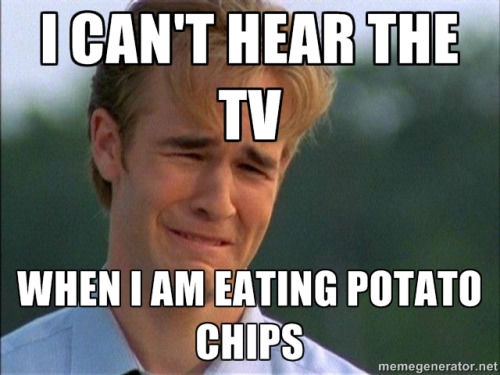

In [59]:
itorch.image(firstworld)

In [60]:
forward_image(vgg, "../../216098-First-World-Problems.jpg");
features = vgg.modules[43].output

In [61]:
newpred = logistic:forward(features)
confidence, index = torch.max(newpred,1)

In [62]:
classes[index[1]]

1990s-First-World-Problems	


Correct!

In [63]:
confidence[1]

0.98762601613998	


With a confidence > 98%!